# Nonlinear least squares and parameter estimation

Up until now, we have looked at problems where we can fit a straight line or a polynomial to data in a single step, obtaining a unique solution that's guaranted to maximize the likelihood (or equivalently, minimize the misfit between the model and observations. Here, we will look at a couple of examples of non-linear curve fitting or parameter estimation.

In [24]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

The code below will generate some synthetic data. We are going to try to fit a function of the form 

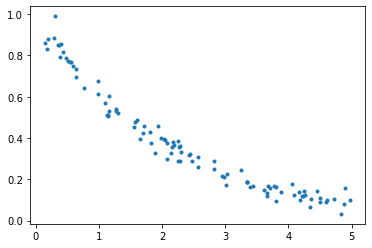

In [25]:
# generate synthetic data for fitting
x = 5*np.random.rand(100,1)
a_true = 1.0
b_true = 2.0
sigma = 0.03
y = a_true*np.exp(-x/b_true) + sigma*np.random.randn(100,1)
plt.figure()
plt.plot(x,y,'.')
plt.show()

We now want to fit a function of the form:
$$
f(x) = A \exp(-x/B)
$$
to the data. In order to do so, we can re-couch the problem as one of residual minimization. We want to minimize the *residual*, defined as the 2-norm of the misfit between the data and the model.

In [26]:
# define a function representing the model
def f(parameters,x=x,y=y):
    a=parameters[0]
    b=parameters[1]
    return a*np.exp(-x/b)

# define a function that will calculate the value of the residual, 
#given estimates for the parameters
def residual(parameters,x=x,y=y):
    delta_y = f(parameters) - y # This is the misfit.
    return np.sqrt(np.sum(delta_y**2))

def plot_solution(parameters,x=x,y=y):
    plt.figure()
    plt.plot(x,y)
    plt.plot(x,f(parameters))
    plt.show()

Make plots illustrating the value of the residual vs. a & b

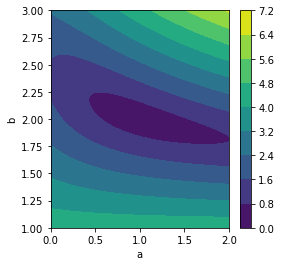

In [27]:
%matplotlib inline
ntest = 100 # number of values to try along each axis
delta = 1.0
exact_parameters = [a_true,b_true]
fig, (ax1) = plt.subplots(1,1,figsize=(4,4))
a = np.linspace(a_true-delta,a_true+delta,ntest)
b = np.linspace(b_true-delta,b_true+delta,ntest)

r_ab = np.zeros((ntest,ntest))
for i in range(ntest):
    for j in range(ntest):
        parameters = [a[i],b[j]]
        r_ab[i,j] = residual(parameters)
co=ax1.contourf(a,b,r_ab)
plt.colorbar(co,ax=ax1)
ax1.set_xlabel('a')
ax1.set_ylabel('b')
plt.show()

# Make a 3D plot of the misfit

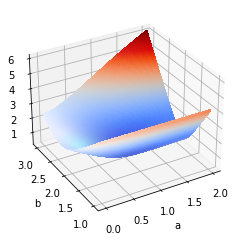

In [5]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure()
from matplotlib import cm
from matplotlib.colors import LightSource

ax = fig.add_subplot(111,projection='3d')
ax.view_init(30,-120)

ls = LightSource(azdeg=0, altdeg=90)
cmap = cm.coolwarm
rgb = ls.shade(r_ab, cmap)
aa,bb = np.meshgrid(a,b)
# Plot the surface
ax.plot_surface(aa,bb,r_ab,cmap=cmap,rstride=1,cstride=1,
                facecolors=rgb,antialiased=False,shade=False)
ax.set_xlabel('a')
ax.set_ylabel('b')
plt.show()

# Implement the grid search from class

In [28]:
# First, let's try a kind of crummy grid search algorithm (see Bevington chapter 8)
# Bevington's algorithm is slightly better than this one in that it usees a parabolic fit to fine-tune the last step.
aguess = np.array([5.0,6.0]) # initial guess at the parameters a and b
def my_gridsearch(function,aguess,delta=None,maxiter=100):
    # the third, optional, argument is a list of increment values by which we perturb the parameters
    nparam = len(aguess)
    if delta is None:
        delta=np.ones(aguess.shape)*.01        
    current_a = aguess # current value of the parameters
    a_archive = []
    a_archive.append(current_a)
    iter=1
    while iter<maxiter:
        f_begin = function(current_a)
        for i in range(nparam):
            # determine whether to search in +ive or -ve direction:
            aplus = current_a.copy() # note - you need to actually make a copy of the array here!!
            aplus[i] += delta[i]
            aminus = current_a.copy()
            aminus[i] -= delta[i]

            # evaluate the function at the current location and in the +/- directions
            f = function(current_a)
            fminus = function(aminus)
            fplus = function(aplus)
            if( fplus < f):
                direction = 1.0
            else:
                direction = -1.0
            while(True):
                # continue to search in decreasing direction
                f = function(current_a)
                a_new = current_a.copy()
                a_new[i] += direction*delta[i]
                fnew = function(a_new)
                if(fnew > f):
                    break
                elif (fnew < f): # accept the new solution
                    current_a = a_new.copy()
                    a_archive.append(current_a.copy())
                else:
                    break
            iter +=1
        f_end = function(current_a)
        if( np.abs(f_end-f_begin)/np.abs(f_begin) < .01 ):
            # if improvemnet becomes sufficiently small, stop optimization
            print('change is small. stopping')
            break
    return current_a,a_archive
abest,a_archive = my_gridsearch(residual,aguess)
print(abest)

change is small. stopping
[0.99 2.04]


/tmp/ipykernel_4750/3443924681.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-x/b)


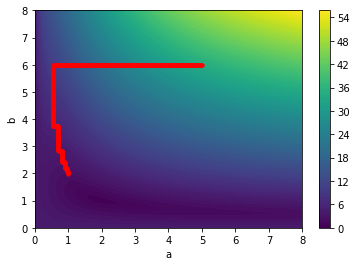

In [7]:
%matplotlib inline
a_archive = np.array(a_archive)

a = np.linspace(0,8,ntest)
b = np.linspace(0,8,ntest)

r_ab = np.zeros((ntest,ntest))
for i in range(ntest):
    for j in range(ntest):
        parameters = [a[i],b[j]]
        r_ab[i,j] = residual(parameters)


fig,ax1 = plt.subplots(1,1)
co=ax1.contourf(a,b,r_ab,100)
plt.colorbar(co,ax=ax1)
ax1.plot(a_archive[:,0],a_archive[:,1],'r.')
ax1.set_xlabel('a')
ax1.set_ylabel('b')

plt.show()

# Implement MCMC from class

The likelihood of obtaining data $\underline{d}$ given parameters $\underline{m}$ is described by a normal distribution:
$$
p(d|m) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp \left(-\frac{1}{2}\chi ^2\right)
$$
The likelihood can become very small due to the exponential term and we need to calculate a ratio of likelihoods, which can lead to a division by zero (error) on the computer. To work around this, we calculate the (natural) logarithm of the likelihood:
$$
\log(p(d|m)) = \log(1) - \frac{1}{2}\log(2\pi\sigma^2) -\frac{1}{2}\chi ^2
$$
The probability of accepting a new solution $m'$ is
$$
\alpha = min\left[\frac{p(d|m')}{p(d|m)} ,1\right]
$$
We also calculate this in log space:
$$
\log(\alpha) = min\left[\log(p(d|m'))-\log(p(d|m)) ,0\right]
$$

In [84]:
def likelihood(parameters,x=x,y=y,var=sigma**2):
    # return the logarithm of the likelihood
    return np.log(1) - 1/2*np.log(2.0*np.pi*var) - 0.5*residual(parameters,x,y)/var

def my_mcmc(likelihood_function,aguess=aguess,num_steps=1e6):
    n = len(aguess)
    # start with an accepted soluition
    a_accepted = aguess.copy()
    p_accepted = likelihood_function(aguess)
    # propose a change
    # choose one of the parameters at random
    step = 1
    a_store = []
    while step < num_steps:
        i = np.random.randint(n) # pick one of 0,1,...,(n-1) at random
        perturbation_size = 1e-3
        a_proposed = a_accepted.copy() # get a new proposed solution
        a_proposed[i] = a_proposed[i] + perturbation_size*np.random.randn()
        p_proposed = likelihood_function(a_proposed)
        # note that we calculate the logarithm of the acceptance probability to avoid a division by zero.
        log_acceptance_probability = p_proposed - p_accepted
        if log_acceptance_probability > 0.0 or np.log(np.random.rand()) < log_acceptance_probability:
            # accept the new solution.
            a_accepted = a_proposed.copy()
            p_accepted = p_proposed
        step = step + 1
        if 0 == step % 100: # save the solution every 100th iteration
            a_store.append(a_accepted.copy())
    
    return a_accepted,np.array(a_store)

a,a_archive = my_mcmc(likelihood,aguess=aguess,num_steps=100000)
print("Solution at last step: ",a)

Solution at last step:  [0.99302068 2.01588333]


# Plot the path taken by the MCMC solution

Note that the 'jet' colormap is used to indicate the position within the markov chain.

/tmp/ipykernel_4750/3443924681.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return a*np.exp(-x/b)


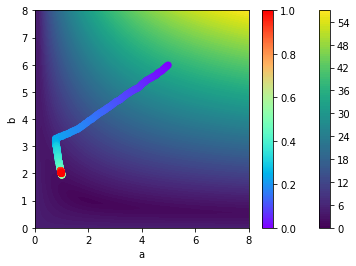

In [110]:
a = np.linspace(0,8,ntest)
b = np.linspace(0,8,ntest)

r_ab = np.zeros((ntest,ntest))
for i in range(ntest):
    for j in range(ntest):
        parameters = [a[i],b[j]]
        r_ab[i,j] = residual(parameters)

fig,ax1 = plt.subplots(1,1)
co=ax1.contourf(a,b,r_ab,100)
plt.colorbar(co,ax=ax1)
h1=ax1.scatter(a_archive[:,0],a_archive[:,1],c=np.linspace(0,1,a_archive.shape[0]),cmap=plt.get_cmap('rainbow'))
ax1.set_xlabel('a')
ax1.set_ylabel('b')
plt.colorbar(h1,ax=ax1)
plt.show()

In [104]:
a_archive[:,0].shape

(1000,)

# Obtain a least squares solution using SciPy

In [8]:
initial_guess = [0.5,1.75] #a,b as an initial guess
solution = opt.least_squares( residual, initial_guess)
print('a=',solution.x[0])
print('b=',solution.x[1])


a= 1.020424146507391
b= 1.955134147835508


# Solve it as a global optimization problem using SciPy

Another way to treat this problem is to view it as a **global optimization**  problem. That is, we are trying to find the values of parameters $\underline{p}$ that minimize some (potentially very complicated) function $f(\underline{p})$. In the case of the problem at hand, $f(\underline{p})$ is just the misfit (in the 2-norm) between the model and the data. SciPy contains several functions that perform this kind of global optimization using brute force (`scipy.optimize.brute`) or various more sophisticated algorithms. Although the example here has a single local minimum (shown above), many problems of geological interest do not, and we must resort to complicated algorithms to try to find the global minimum of a function of many variables. SciPy has a variety of *black box* optimization routines for finding minimum, and I demonstrate a couple of these below. In general, the global optimization functions will perform best when you can provide reasonable estimatese or constraints on the *bounds* of the parameters. For instance, we can supply *bounds*  on the parameters a and b:

$0\le a \le 100$

$0 \le b \le 10$

The bounds are passed as arguments to the global optimization functions like so:
```bounds = [[a_min,a_max],[b_min,b_max],...]```
If we were estimating N parameters, we would supply an Nx2 list of bounds on each of the N parameters.


In [9]:
# Use  the 'dual annealing' algorithm
bounds = [[.01,100],[.01,10]]
opt.dual_annealing(residual,bounds) # we pass the name of the function that we are mininizing and the bounds.

     fun: 0.2844867259659034
 message: ['Maximum number of iteration reached']
    nfev: 4085
    nhev: 0
     nit: 1000
    njev: 28
  status: 0
 success: True
       x: array([1.0204063, 1.9551833])

In [10]:
# Use brute force (not recommended for more than a couple of parameters)
opt.brute(residual,bounds,Ns=10)

array([1.02038972, 1.95519398])

# Evil functions with multiple local minima

Now, let's try to find the minima of a more complicated function that posesses local minima


In [11]:
def f(params):
    x=params[0]
    y=params[1]
    return 0.1*np.sqrt(x**2 + y**2) - np.cos(np.pi*x/5)*np.cos(np.pi*y/5)

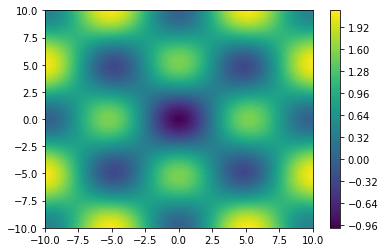

In [12]:
xx = np.linspace(-10,10,ntest)
yy = np.linspace(-10,10,ntest)
fvals = np.zeros((ntest,ntest))
for i in range(ntest):
    for j in range(ntest):
        p=[xx[i],yy[j]]
        fvals[j,i] = f(p)
plt.figure()
plt.contourf(xx,yy,fvals,100)
plt.colorbar()
plt.show()

The global minimum of $f$ occurs at the origin, but there are many other local minima, as seen above.

In [13]:
bounds = [[-10,10],[-10,10]]
opt.brute(f,bounds,Ns=20,finish=opt.fmin)

array([3.00236013e-05, 1.09829652e-05])

In [14]:
# Note - this gets stuck in a local minimum!!
opt.dual_annealing(residual,bounds)

     fun: 2.4391308725353507
 message: ['Maximum number of iteration reached']
    nfev: 4022
    nhev: 0
     nit: 1000
    njev: 7
  status: 0
 success: True
       x: array([-4.31499635, -2.8150581 ])

In [15]:
# try least squares with a bad initial guess
initial_guess = [5,5]
solution = opt.least_squares( residual, initial_guess)
print(solution)

 active_mask: array([0., 0.])
        cost: 3.1860475842281466
         fun: array([2.52430093])
        grad: array([-3.70812506e-06, -3.70812506e-06])
         jac: array([[-1.46897108e-06, -1.46897108e-06]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: 9
  optimality: 3.7081250627193624e-06
      status: 2
     success: True
           x: array([9.81933832, 9.81933832])


In [16]:
solution = opt.basinhopping(residual,initial_guess,niter=1000,T=1.0,stepsize=4.01)
print(solution)

                        fun: 2.4391308725353484
 lowest_optimization_result:       fun: 2.4391308725353484
 hess_inv: array([[0.69442479, 0.4219543 ],
       [0.4219543 , 0.41733919]])
      jac: array([5.96046448e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([3.53542608, 6.37722983])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 27693
                        nit: 1000
                       njev: 9231
                          x: array([3.53542608, 6.37722983])


# Solve